In [2]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re

In [3]:
def normalize_spaces(text):
    #spaces and Unicode-spaces and other non-alphabetical letters in the names of the nifti or xml files should be normalized
    #original problem: ROI names in the xml label files had several spaces/Unicode signs between words instead of one
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        normalized_text = text.replace('\xa0', ' ')
        normalized_text = re.sub(r'\s+', ' ', normalized_text).strip()
        return normalized_text.strip()
    return text

In [4]:
def prepare_effect_sizes_dataframe(effect_sizes_file_path, file_type, raw_roi_name_col, effect_size_col, diagnosis_col, target_atlas_name="neuromorphometrics"):
    
    #loads effectsizes from df for plotting on brains 
    #cleanes up the ROI names 
   
    try:
        if file_type == 'csv':
            df = pd.read_csv(effect_sizes_file_path)
        elif file_type == 'excel':
            df = pd.read_excel(effect_sizes_file_path)
        else:
            print(f"Error: wrong datatype '{file_type}'. Please use csv or Excel")
            return None

        #print(f"raw effect sizes loaded from : {effect_sizes_file_path}")

        required_cols = [raw_roi_name_col, effect_size_col, diagnosis_col]
        for col in required_cols:
            if col not in df.columns:
                print(f"Error: Column '{col}' not found in df")
                print(f"Available columns: {df.columns.tolist()}")
                return None

        df_filtered = df[df[raw_roi_name_col].astype(str).str.contains(target_atlas_name, na=False, case=False)]
        #print(f"Df filtered for:'{target_atlas_name}'; Original rows: {len(df)}, Filtered rows: {len(df_filtered)}")

        if df_filtered.empty:
            print(f"No rowsd found in atlas: '{target_atlas_name}'")
            return None

        df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
            lambda x: x.split(f"{target_atlas_name}_", 1)[1] if f"{target_atlas_name}_" in x else x
        )

        suffixes_to_remove = ['_Vgm', '_Vwm', '_csf']

        df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
            lambda x: x
        )

        for suffix in suffixes_to_remove:
            df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Cleaned'].apply(
                lambda x: x.replace(suffix, '') if isinstance(x, str) and x.endswith(suffix) else x
            )

        df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Cleaned'].apply(normalize_spaces)

        # Include the diagnosis column here
        cleaned_df = df_filtered[['ROI_Name_Cleaned', effect_size_col, diagnosis_col]].copy()
        cleaned_df.rename(columns={'ROI_Name_Cleaned': 'ROI_Name'}, inplace=True)

        #print(f"ROI-Names cleaned up & normalized. e.g.:")
        if not cleaned_df.empty and raw_roi_name_col in df.columns:
            example_idx = cleaned_df.index[0]
            original_raw_name_for_example = df.loc[example_idx, raw_roi_name_col]
            cleaned_name_for_example = cleaned_df.loc[example_idx, 'ROI_Name']
            print(f"Original: '{original_raw_name_for_example}' -> Cleaned up : '{cleaned_name_for_example}'")
        else:
            print("Error: original df empty")

        return cleaned_df

    except FileNotFoundError:
        print(f"Error: Effectsizes not found : {effect_sizes_file_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return None
    except Exception as e:
        print(f"Fehler beim Laden oder Verarbeiten der Effektgrößen-Datei: {e}")
        return None

In [5]:
#3D visualization on a neuromorphometrics atlas with colored effect sizes
#needs: cleaned up df with roi names

# def plot_brain_with_effect_sizes_neuromorphometrics(
#     atlas_nifti_path,
#     label_map_xml_path,
#     effect_sizes_df_cleaned,
#     roi_name_col_cleaned,
#     effect_size_col,
#     title_suffix="", # New argument for plot title
#     output_filename_prefix="brain_effect_sizes",
#     vmax=None,
#     cmap='viridis',
#     plot_interactive=False):

#     # 1. load the atlas (e.g. neuromorphometrics)
#     try:
#         atlas_img = nib.load(atlas_nifti_path)
#         atlas_data = atlas_img.get_fdata()
#         #print(f"NeuroMorphometrics Atlas erfolgreich geladen von: {atlas_nifti_path}")
#     except FileNotFoundError:
#         print(f"Fehler: Die NIfTI-Datei des Atlases wurde nicht gefunden unter: {atlas_nifti_path}")
#         print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
#         return
#     except Exception as e:
#         print(f"Fehler beim Laden des NeuroMorphometrics Atlases: {e}")
#         return

#     # 2. Label-Map XML-file parsen and normalize spaces
#     try:
#         tree = ET.parse(label_map_xml_path)
#         root = tree.getroot()
#         #print(f"Label-Map XML-Datei erfolgreich geladen von: {label_map_xml_path}")
#     except FileNotFoundError:
#         print(f"Fehler: Die Label-Map XML-Datei wurde nicht gefunden unter: {label_map_xml_path}")
#         print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
#         return
#     except Exception as e:
#         print(f"Fehler beim Parsen der Label-Map XML-Datei: {e}")
#         return

#     label_map = {}
#     for label in root.findall('Label'):
#         name = normalize_spaces(label.find('Name').text)
#         number = int(label.find('Number').text)
#         label_map[name] = number
#     print("ROI-Namen aus Label-Map normalisiert.")

#     # 3. one empty brain volume
#     effect_map_data = np.zeros_like(atlas_data, dtype=float)

#     # 4. Effect sizes -> ROI-Nummern -> new volume
#     found_rois = []
#     missing_rois = []

#     if roi_name_col_cleaned not in effect_sizes_df_cleaned.columns or effect_size_col not in effect_sizes_df_cleaned.columns:
#         print(f"Fehler: Die erforderlichen Spalten '{roi_name_col_cleaned}' oder '{effect_size_col}'")
#         print("wurden im bereitgestellten DataFrame nicht gefunden. Überprüfen Sie die prepare_function.")
#         return

#     for index, row in effect_sizes_df_cleaned.iterrows():
#         roi_name = str(row[roi_name_col_cleaned])
#         effect_size = row[effect_size_col]

#         if roi_name in label_map:
#             roi_number = label_map[roi_name]
#             if np.any(atlas_data == roi_number):
#                 effect_map_data[atlas_data == roi_number] = effect_size
#                 found_rois.append(roi_name)
#             else:
#                 missing_rois.append(f"{roi_name} (ROI-Nummer {roi_number} nicht im Atlas gefunden)")
#         else:
#             missing_rois.append(f"{roi_name} (Nicht in Label-Map gefunden)")

#     effect_map_img = nib.Nifti1Image(effect_map_data, atlas_img.affine, atlas_img.header)

#     if vmax is None:
#         max_val = np.max(np.abs(effect_map_data))
#         if max_val == 0:
#             vmax = 1.0
#             print("Info: Alle Effektgrößen sind Null. vmax wurde auf 1.0 gesetzt.")
#         else:
#             vmax = max_val
#             print(f"\nvmax wurde automatisch auf den Maximalwert der absoluten Effektgrößen gesetzt: {vmax:.2f}")

#     #print(f"\nErstelle statische orthogonale Visualisierung für {title_suffix}...")
#     fig_ortho = plotting.plot_stat_map(
#         effect_map_img,
#         bg_img=atlas_img,
#         display_mode='ortho',
#         colorbar=True,
#         cmap=cmap,
#         vmax=vmax,
#         title=f"Gehirn-Effektgrößen (Orthogonal) - {title_suffix}",
#         output_file=None 
#     )

#     plt.show() # Shows the static plot

#     #interactive plot
#     if plot_interactive:
#         print(f"\nErstelle interaktive 3D-Visualisierung für {title_suffix} (öffnet im Browser oder Inline-Fenster)...")
#         interactive_plot = plotting.view_img(
#             effect_map_img,
#             bg_img=atlas_img,
#             colorbar=True,
#             cmap=cmap,
#             vmax=vmax,
#             title=f"Interaktive Effektgrößen-Karte - {title_suffix}"
#         )
#         print("Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.")
        
#         return interactive_plot



In [15]:
def plot_brain_with_effect_sizes_neuromorphometrics(
    atlas_nifti_path,
    label_map_xml_path,
    effect_sizes_df_cleaned,
    roi_name_col_cleaned,
    effect_size_col,
    title_suffix="", 
    output_filename_prefix="brain_effect_sizes",
    vmax=None,
    vmin=None, 
    cmap='viridis',
    plot_interactive=False,
    only_positive=True):  # NEW PARAMETER

    # 1. load the atlas (e.g. neuromorphometrics)
    try:
        atlas_img = nib.load(atlas_nifti_path)
        atlas_data = atlas_img.get_fdata()
    except FileNotFoundError:
        print(f"Fehler: Die NIfTI-Datei des Atlases wurde nicht gefunden unter: {atlas_nifti_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return
    except Exception as e:
        print(f"Fehler beim Laden des NeuroMorphometrics Atlases: {e}")
        return

    # 2. Label-Map XML-file parsen and normalize spaces
    try:
        tree = ET.parse(label_map_xml_path)
        root = tree.getroot()
    except FileNotFoundError:
        print(f"Fehler: Die Label-Map XML-Datei wurde nicht gefunden unter: {label_map_xml_path}")
        print("Bitte überprüfe den Pfad und stelle sicher, dass die Datei existiert.")
        return
    except Exception as e:
        print(f"Fehler beim Parsen der Label-Map XML-Datei: {e}")
        return

    label_map = {}
    for label in root.findall('Label'):
        name = normalize_spaces(label.find('Name').text)
        number = int(label.find('Number').text)
        label_map[name] = number
    print("ROI-Namen aus Label-Map normalisiert.")

    # 3. Filter effect sizes if only_positive is True
    if only_positive:
        effect_sizes_df_filtered = effect_sizes_df_cleaned[effect_sizes_df_cleaned[effect_size_col] > 0].copy()
        print(f"Filtering for positive values only: {len(effect_sizes_df_cleaned)} -> {len(effect_sizes_df_filtered)} ROIs")
    else:
        effect_sizes_df_filtered = effect_sizes_df_cleaned.copy()

    # 4. one empty brain volume
    effect_map_data = np.zeros_like(atlas_data, dtype=float)

    # 5. Effect sizes -> ROI-Nummern -> new volume (using filtered dataframe)
    found_rois = []
    missing_rois = []

    if roi_name_col_cleaned not in effect_sizes_df_filtered.columns or effect_size_col not in effect_sizes_df_filtered.columns:
        print(f"Fehler: Die erforderlichen Spalten '{roi_name_col_cleaned}' oder '{effect_size_col}'")
        print("wurden im bereitgestellten DataFrame nicht gefunden. Überprüfen Sie die prepare_function.")
        return

    for index, row in effect_sizes_df_filtered.iterrows():
        roi_name = str(row[roi_name_col_cleaned])
        effect_size = row[effect_size_col]

        if roi_name in label_map:
            roi_number = label_map[roi_name]
            if np.any(atlas_data == roi_number):
                effect_map_data[atlas_data == roi_number] = effect_size
                found_rois.append(roi_name)
            else:
                missing_rois.append(f"{roi_name} (ROI-Nummer {roi_number} nicht im Atlas gefunden)")
        else:
            missing_rois.append(f"{roi_name} (Nicht in Label-Map gefunden)")

    effect_map_img = nib.Nifti1Image(effect_map_data, atlas_img.affine, atlas_img.header)

    # 6. Adjust vmax calculation for positive-only values
    if vmax is None:
        if only_positive:
            max_val = np.max(effect_map_data) if np.max(effect_map_data) > 0 else 1.0
        else:
            max_val = np.max(np.abs(effect_map_data))
        
        if max_val == 0:
            vmax = 1.0
            print("Info: Alle Effektgrößen sind Null. vmax wurde auf 1.0 gesetzt.")
        else:
            vmax = max_val
            print(f"\nvmax wurde automatisch auf den Maximalwert gesetzt: {vmax:.2f}")

    # 7. Create static orthogonal visualization
    title_text = f"Gehirn-Effektgrößen (Orthogonal) - {title_suffix}"
    
    fig_ortho = plotting.plot_stat_map(
        effect_map_img,
        bg_img=atlas_img,
        display_mode='ortho',
        colorbar=True,
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,  # Set vmin to 0 for positive-only
        title=title_text,
        output_file=None 
    )

    plt.show() # Shows the static plot

    # 8. Interactive plot
    if plot_interactive:
        interactive_title = f"Interaktive Effektgrößen-Karte - {title_suffix}"

            
        print(f"\nErstelle interaktive 3D-Visualisierung für {title_suffix} (öffnet im Browser oder Inline-Fenster)...")
        interactive_plot = plotting.view_img(
            effect_map_img,
            bg_img=atlas_img,
            colorbar=True,
            cmap=cmap,
            vmax=vmax,
            vmin=vmin,  # Set vmin to 0 for positive-only
            title=interactive_title
        )
        print("Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.")
        
        return interactive_plot


--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---
Original: 'neuromorphometrics_3rd Ventricle_Vgm' -> Cleaned up : '3rd Ventricle'


/tmp/ipykernel_744626/3076503778.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
/tmp/ipykernel_744626/3076503778.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
/tmp/ipykernel_744626/3076503778.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 105 ROIs


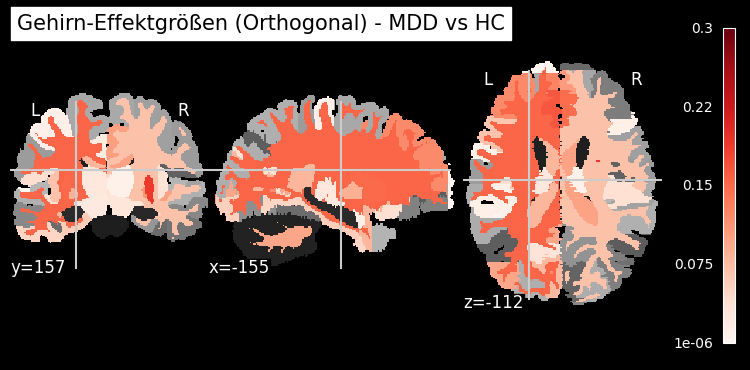


Erstelle interaktive 3D-Visualisierung für MDD vs HC (öffnet im Browser oder Inline-Fenster)...


/tmp/ipykernel_744626/3630346876.py:117: UserWarning: vmin cannot be chosen when cmap is symmetric
  interactive_plot = plotting.view_img(
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für MDD (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_MDD_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 98 ROIs


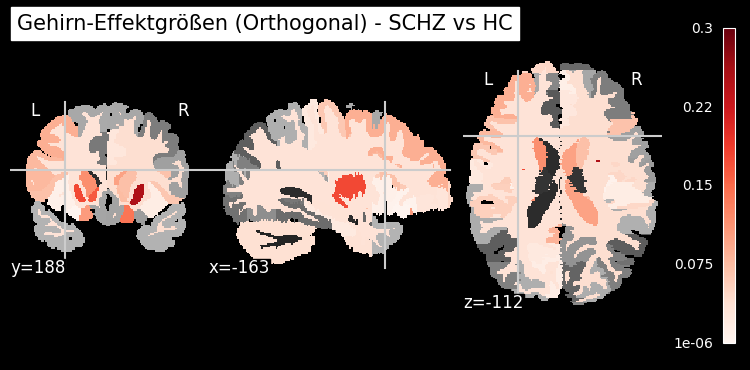


Erstelle interaktive 3D-Visualisierung für SCHZ vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für SCHZ (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_SCHZ_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 97 ROIs


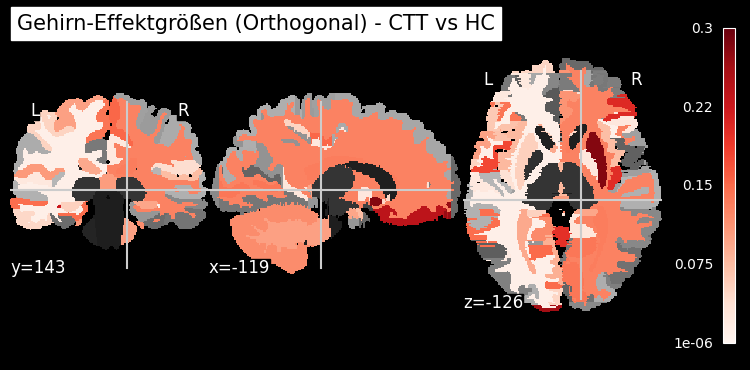


Erstelle interaktive 3D-Visualisierung für CTT vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 79 ROIs


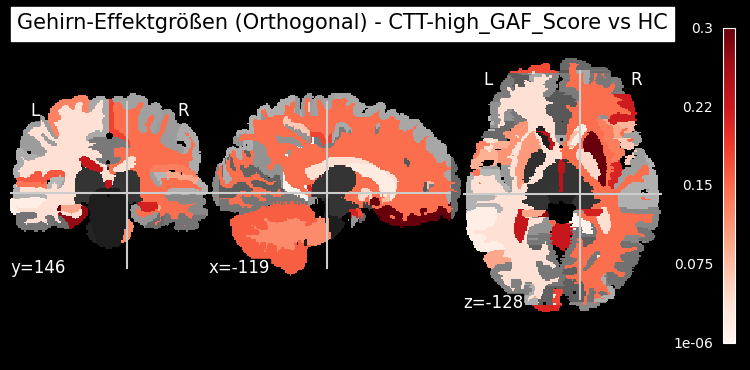


Erstelle interaktive 3D-Visualisierung für CTT-high_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-high_GAF_Score (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-high_GAF_Score_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 89 ROIs


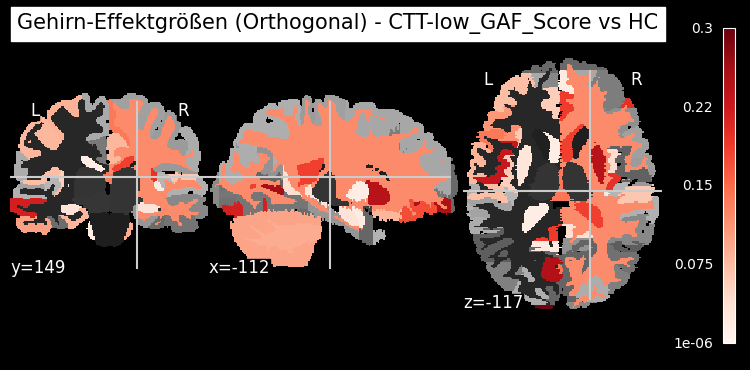


Erstelle interaktive 3D-Visualisierung für CTT-low_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT-low_GAF_Score (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT-low_GAF_Score_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 71 ROIs


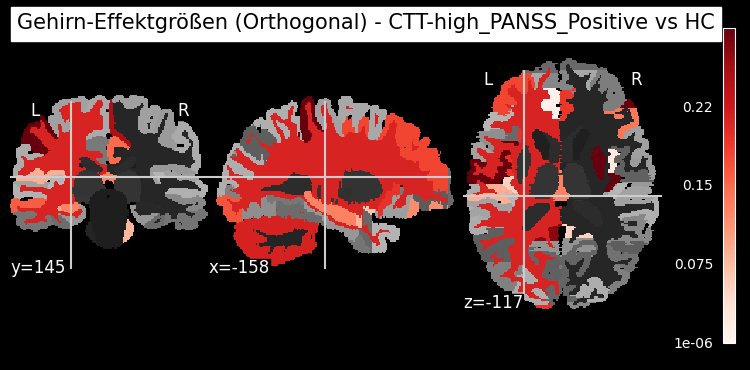


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Positive vs HC (öffnet im Browser oder Inline-Fenster)...


KeyboardInterrupt: 

In [7]:
if __name__ == '__main__':
    neuro_morphometrics_atlas_path = "/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/neuromorphometrics.nii"
    label_map_xml_path = '/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/atlases_labels/1103_3_glm_LabelMap.xml'
    my_actual_effect_sizes_csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_V_g_m_neuromorphometrics_lpba40_20250619_1402_20250619_193846/effect_sizes_HC.csv"
    
    # Define the diagnosis column name
    diagnosis_column_name = 'Diagnosis' # <--- Make sure this matches your CSV column name exactly
    
    print("\n--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---")
    all_effect_sizes_df = prepare_effect_sizes_dataframe(
        effect_sizes_file_path=my_actual_effect_sizes_csv_path,
        file_type='csv',
        raw_roi_name_col='ROI_Name',
        effect_size_col='Cliffs_Delta',
        diagnosis_col=diagnosis_column_name, # Pass the diagnosis column name
        target_atlas_name="neuromorphometrics"
    )
    
    if all_effect_sizes_df is not None and not all_effect_sizes_df.empty:
        # Identify unique diagnoses, excluding 'HC'
        norm_diagnosis = 'HC'
        unique_diagnoses = all_effect_sizes_df[diagnosis_column_name].unique()
        diagnoses_to_plot = [d for d in unique_diagnoses if d != norm_diagnosis]
        
        if not diagnoses_to_plot:
            print(f"Keine anderen Diagnosen als '{norm_diagnosis}' zum Plotten gefunden.")
        else:
            output_dir = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots"
            os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist
            
            for diagnosis in diagnoses_to_plot:
                df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()
                
                if df_for_diagnosis.empty:
                    print(f"Keine Daten für Diagnose '{diagnosis}'. Überspringe Plot.")
                    continue
                
                # Generate a filename prefix for the current diagnosis
                current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_effect_sizes_{diagnosis.replace(' ', '_')}_positive_only")
                
                interactive_viewer = plot_brain_with_effect_sizes_neuromorphometrics(
                    atlas_nifti_path=neuro_morphometrics_atlas_path,
                    label_map_xml_path=label_map_xml_path,
                    effect_sizes_df_cleaned=df_for_diagnosis,
                    roi_name_col_cleaned='ROI_Name',
                    effect_size_col='Cliffs_Delta',
                    title_suffix=f"{diagnosis} vs {norm_diagnosis}", # Title includes diagnosis
                    output_filename_prefix=current_output_prefix,
                    cmap='Reds',  # Changed to 'Reds' for positive-only values
                    vmax=0.3,
                    plot_interactive=True,
                    only_positive=True  # NEW PARAMETER - set to True for positive-only
                )
                
                if interactive_viewer:
                    interactive_viewer.save_as_html(f"{current_output_prefix}_interactive.html")
                    print(f"Interaktiver Plot für {diagnosis} (nur positive Werte) gespeichert unter: {current_output_prefix}_interactive.html")
            
            print("\nAlle Plots abgeschlossen.")
    else:
        print("\nPlotting übersprungen, da es Probleme bei der Vorbereitung des Effektgrößen-DataFrames gab.")


--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---
Original: 'neuromorphometrics_3rd Ventricle_Vgm' -> Cleaned up : '3rd Ventricle'
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 408 -> 282 ROIs


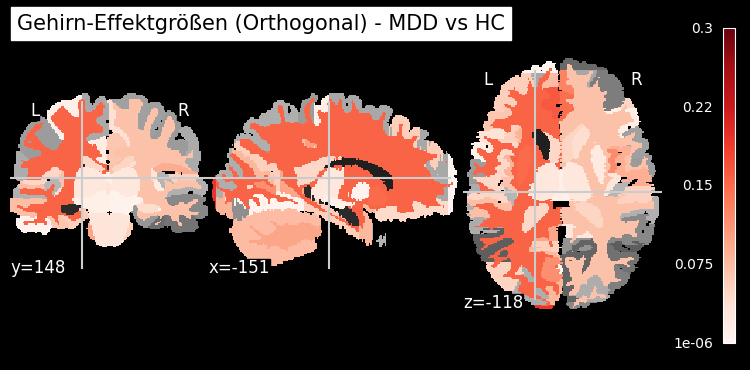


Erstelle interaktive 3D-Visualisierung für MDD vs HC (öffnet im Browser oder Inline-Fenster)...


/tmp/ipykernel_744626/3630346876.py:117: UserWarning: vmin cannot be chosen when cmap is symmetric
  interactive_plot = plotting.view_img(
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für MDD (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_MDD_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 408 -> 275 ROIs


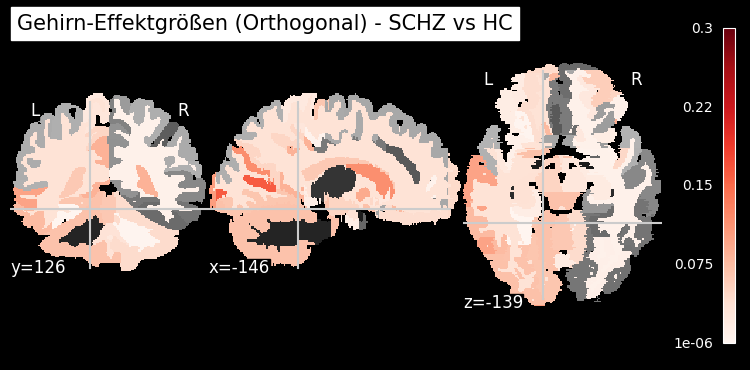


Erstelle interaktive 3D-Visualisierung für SCHZ vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für SCHZ (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_SCHZ_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 408 -> 226 ROIs


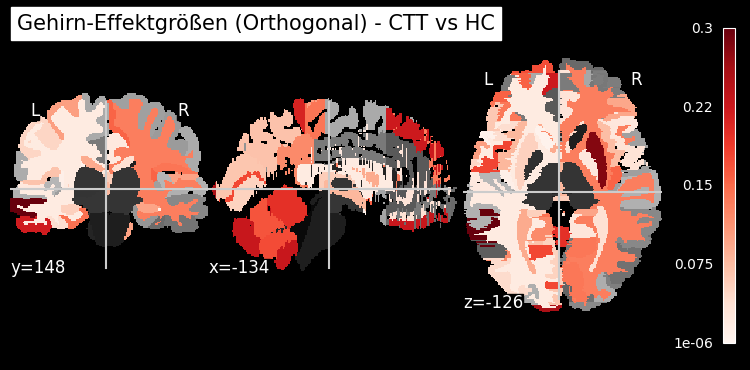


Erstelle interaktive 3D-Visualisierung für CTT vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot für CTT (nur positive Werte) gespeichert unter: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_effect_sizes_CTT_positive_only_interactive.html
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 408 -> 233 ROIs


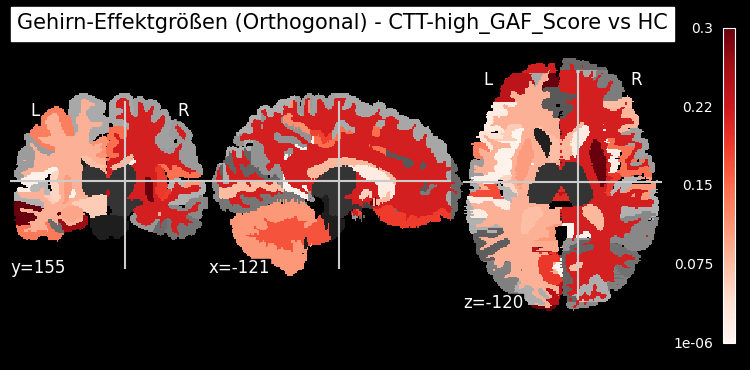


Erstelle interaktive 3D-Visualisierung für CTT-high_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...


KeyboardInterrupt: 

In [10]:
if __name__ == '__main__':
    neuro_morphometrics_atlas_path = "/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/neuromorphometrics.nii"
    label_map_xml_path = '/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/atlases_labels/1103_3_glm_LabelMap.xml'
    my_actual_effect_sizes_csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_Vgm_Vwm_Vcsf_neuromorphometrics_20250530_1143_20250619_190916/effect_sizes_HC.csv"
    
    # Define the diagnosis column name
    diagnosis_column_name = 'Diagnosis' # <--- Make sure this matches your CSV column name exactly
    
    print("\n--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---")
    all_effect_sizes_df = prepare_effect_sizes_dataframe(
        effect_sizes_file_path=my_actual_effect_sizes_csv_path,
        file_type='csv',
        raw_roi_name_col='ROI_Name',
        effect_size_col='Cliffs_Delta',
        diagnosis_col=diagnosis_column_name, # Pass the diagnosis column name
        target_atlas_name="neuromorphometrics"
    )
    
    if all_effect_sizes_df is not None and not all_effect_sizes_df.empty:
        # Identify unique diagnoses, excluding 'HC'
        norm_diagnosis = 'HC'
        unique_diagnoses = all_effect_sizes_df[diagnosis_column_name].unique()
        diagnoses_to_plot = [d for d in unique_diagnoses if d != norm_diagnosis]
        
        if not diagnoses_to_plot:
            print(f"Keine anderen Diagnosen als '{norm_diagnosis}' zum Plotten gefunden.")
        else:
            output_dir = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots"
            os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist
            
            for diagnosis in diagnoses_to_plot:
                df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()
                
                if df_for_diagnosis.empty:
                    print(f"Keine Daten für Diagnose '{diagnosis}'. Überspringe Plot.")
                    continue
                
                # Generate a filename prefix for the current diagnosis
                current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_effect_sizes_{diagnosis.replace(' ', '_')}_positive_only")
                
                interactive_viewer = plot_brain_with_effect_sizes_neuromorphometrics(
                    atlas_nifti_path=neuro_morphometrics_atlas_path,
                    label_map_xml_path=label_map_xml_path,
                    effect_sizes_df_cleaned=df_for_diagnosis,
                    roi_name_col_cleaned='ROI_Name',
                    effect_size_col='Cliffs_Delta',
                    title_suffix=f"{diagnosis} vs {norm_diagnosis}", # Title includes diagnosis
                    output_filename_prefix=current_output_prefix,
                    cmap='Reds',  # Changed to 'Reds' for positive-only values
                    vmax=0.3,
                    plot_interactive=True,
                    only_positive=True  # NEW PARAMETER - set to True for positive-only
                )
                
                if interactive_viewer:
                    interactive_viewer.save_as_html(f"{current_output_prefix}_interactive.html")
                    print(f"Interaktiver Plot für {diagnosis} (nur positive Werte) gespeichert unter: {current_output_prefix}_interactive.html")
            
            print("\nAlle Plots abgeschlossen.")
    else:
        print("\nPlotting übersprungen, da es Probleme bei der Vorbereitung des Effektgrößen-DataFrames gab.")


--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---
Original: 'neuromorphometrics_3rd Ventricle_Vgm' -> Cleaned up : '3rd Ventricle'
Verfügbare Diagnosen: ['MDD', 'SCHZ', 'CTT', 'CTT-high_GAF_Score', 'CTT-low_GAF_Score', 'CTT-high_PANSS_Positive', 'CTT-low_PANSS_Positive', 'CTT-high_PANSS_Negative', 'CTT-low_PANSS_Negative', 'CTT-high_PANSS_General', 'CTT-low_PANSS_General', 'CTT-high_PANSS_Total', 'CTT-low_PANSS_Total', 'CTT-high_BPRS_Total', 'CTT-low_BPRS_Total', 'CTT-high_NCRS_Motor', 'CTT-low_NCRS_Motor', 'CTT-high_NCRS_Affective', 'CTT-low_NCRS_Affective', 'CTT-high_NCRS_Behavioral', 'CTT-low_NCRS_Behavioral', 'CTT-high_NCRS_Total', 'CTT-low_NCRS_Total', 'CTT-high_NSS_Motor', 'CTT-low_NSS_Motor', 'CTT-high_NSS_Total', 'CTT-low_NSS_Total']

INTERAKTIVE PLOTS (einzeln)

--- Interaktiver Plot: MDD vs HC ---


/tmp/ipykernel_744626/3076503778.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Temp'] = df_filtered[raw_roi_name_col].astype(str).apply(
/tmp/ipykernel_744626/3076503778.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI_Name_Cleaned'] = df_filtered['ROI_Name_Temp'].astype(str).apply(
/tmp/ipykernel_744626/3076503778.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 105 ROIs


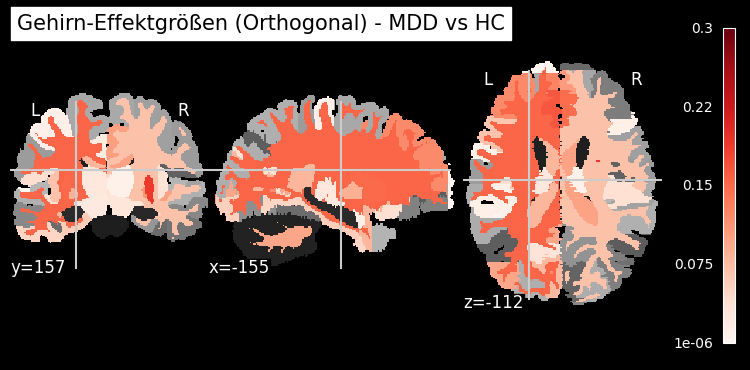


Erstelle interaktive 3D-Visualisierung für MDD vs HC (öffnet im Browser oder Inline-Fenster)...


/tmp/ipykernel_744626/422716940.py:118: UserWarning: vmin cannot be chosen when cmap is symmetric
  interactive_plot = plotting.view_img(
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_MDD_interactive_positive_only_interactive.html

--- Interaktiver Plot: SCHZ vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 98 ROIs


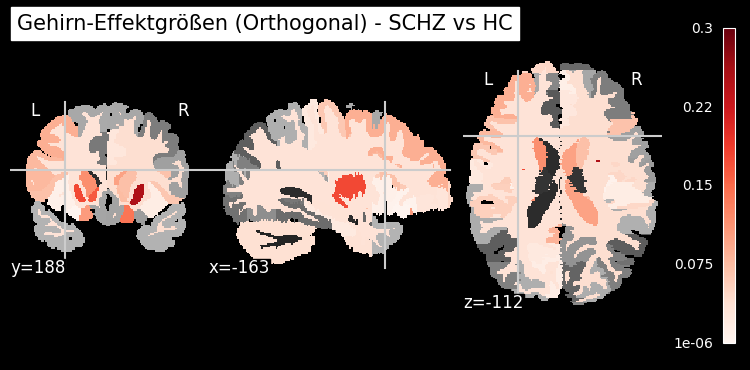


Erstelle interaktive 3D-Visualisierung für SCHZ vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_SCHZ_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 97 ROIs


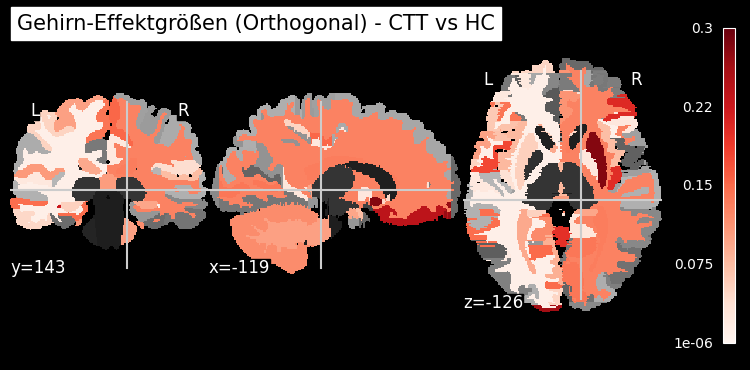


Erstelle interaktive 3D-Visualisierung für CTT vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-high_GAF_Score vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 79 ROIs


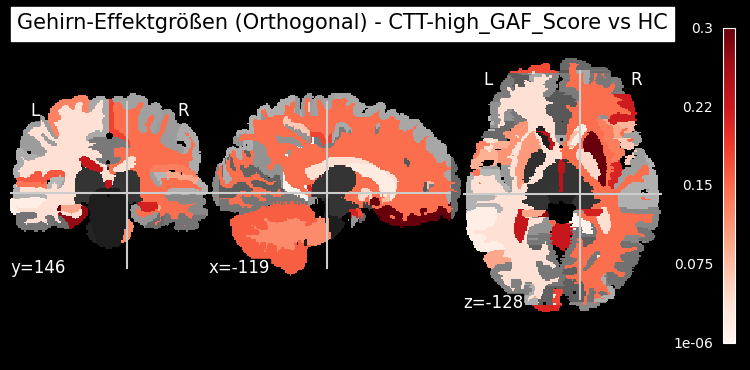


Erstelle interaktive 3D-Visualisierung für CTT-high_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-high_GAF_Score_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-low_GAF_Score vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 89 ROIs


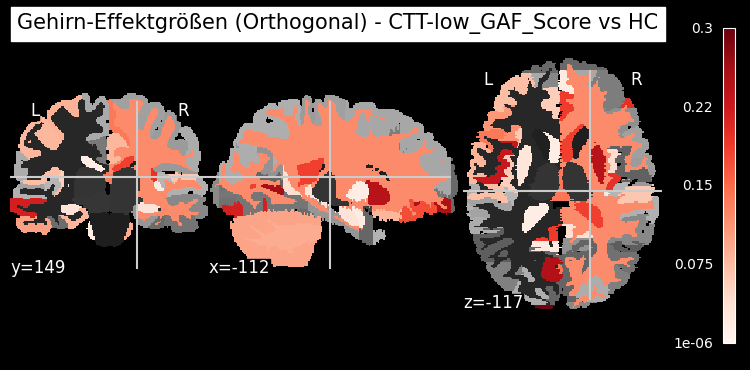


Erstelle interaktive 3D-Visualisierung für CTT-low_GAF_Score vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-low_GAF_Score_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-high_PANSS_Positive vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 71 ROIs


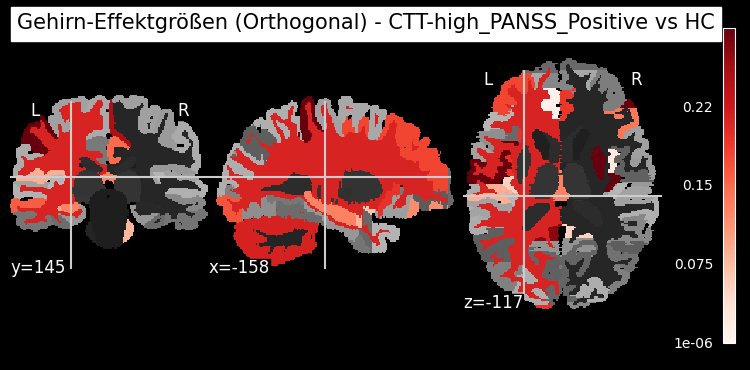


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Positive vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-high_PANSS_Positive_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-low_PANSS_Positive vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 91 ROIs


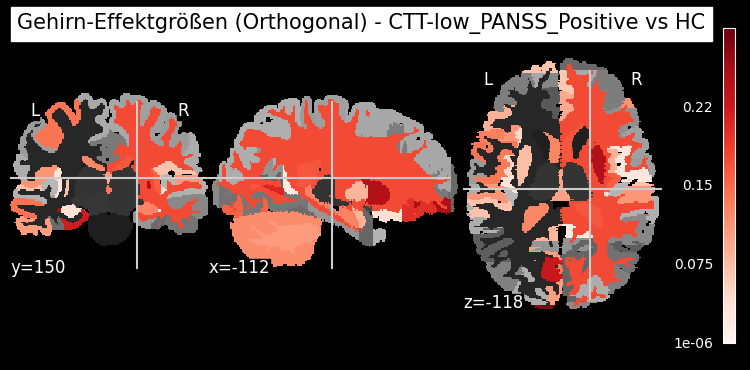


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_Positive vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-low_PANSS_Positive_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-high_PANSS_Negative vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 91 ROIs


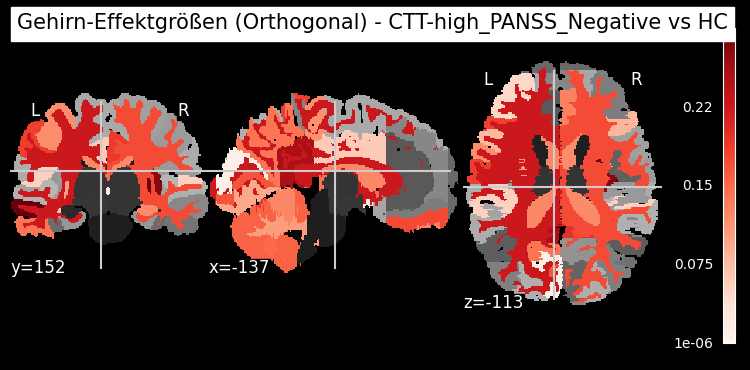


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Negative vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-high_PANSS_Negative_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-low_PANSS_Negative vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 80 ROIs


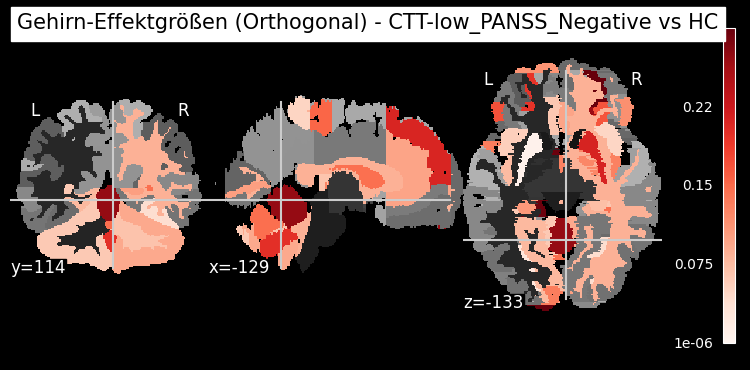


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_Negative vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-low_PANSS_Negative_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-high_PANSS_General vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 87 ROIs


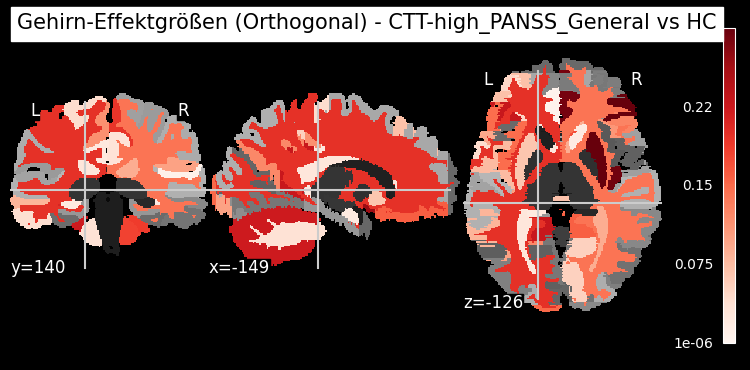


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_General vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-high_PANSS_General_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-low_PANSS_General vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 92 ROIs


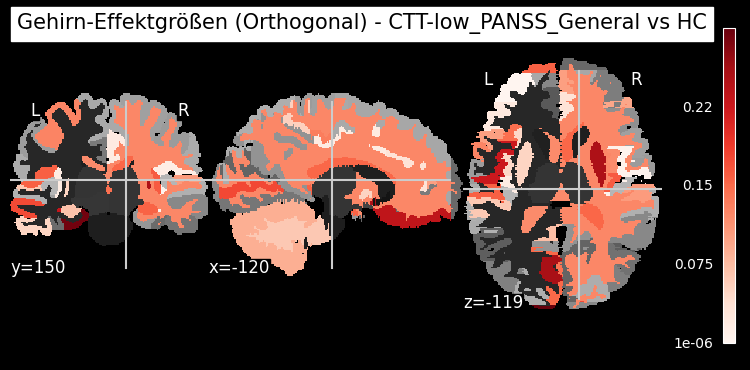


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_General vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-low_PANSS_General_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-high_PANSS_Total vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 86 ROIs


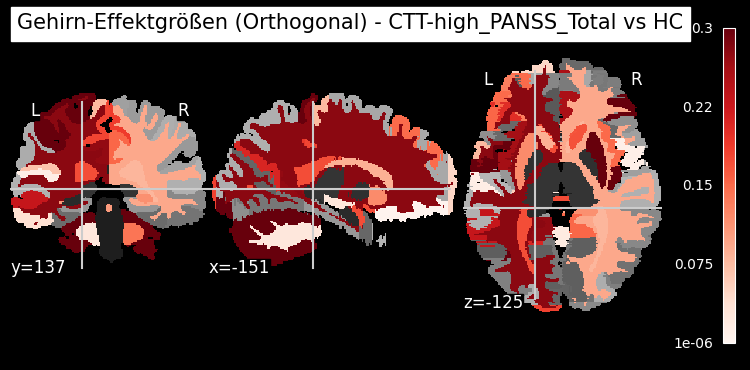


Erstelle interaktive 3D-Visualisierung für CTT-high_PANSS_Total vs HC (öffnet im Browser oder Inline-Fenster)...
Interaktiver Plot generiert. Eventuell musst du das Ausgabefenster des Notebooks scrollen.
Interaktiver Plot gespeichert: /workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots/neuromorphometrics_CTT-high_PANSS_Total_interactive_positive_only_interactive.html

--- Interaktiver Plot: CTT-low_PANSS_Total vs HC ---
ROI-Namen aus Label-Map normalisiert.
Filtering for positive values only: 136 -> 88 ROIs


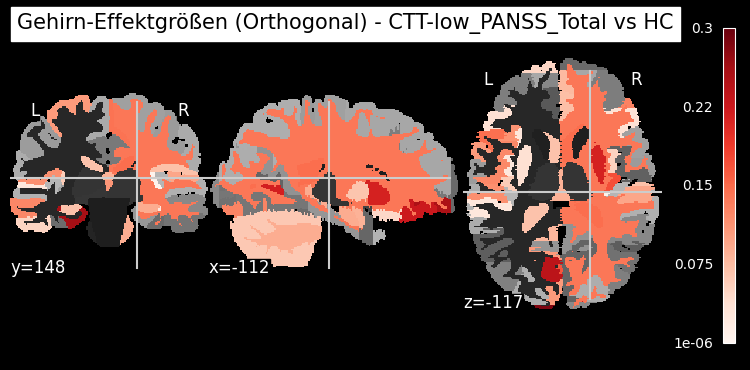


Erstelle interaktive 3D-Visualisierung für CTT-low_PANSS_Total vs HC (öffnet im Browser oder Inline-Fenster)...


KeyboardInterrupt: 

In [16]:
if __name__ == '__main__':
    neuro_morphometrics_atlas_path = "/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/neuromorphometrics.nii"
    label_map_xml_path = '/workspace/project/catatonia_VAE-main_bq/data/atlases_niis/atlases_labels/1103_3_glm_LabelMap.xml'
    my_actual_effect_sizes_csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_V_g_m_neuromorphometrics_lpba40_20250619_1402_20250619_193846/effect_sizes_HC.csv"
    
    # Define the diagnosis column name
    diagnosis_column_name = 'Diagnosis' # <--- Make sure this matches your CSV column name exactly
    
    print("\n--- Vorverarbeitung des gesamten Effektgrößen-DataFrames ---")
    all_effect_sizes_df = prepare_effect_sizes_dataframe(
        effect_sizes_file_path=my_actual_effect_sizes_csv_path,
        file_type='csv',
        raw_roi_name_col='ROI_Name',
        effect_size_col='Cliffs_Delta',
        diagnosis_col=diagnosis_column_name, # Pass the diagnosis column name
        target_atlas_name="neuromorphometrics"
    )
    
    if all_effect_sizes_df is not None and not all_effect_sizes_df.empty:
        # Identify unique diagnoses, excluding 'HC'
        norm_diagnosis = 'HC'
        unique_diagnoses = all_effect_sizes_df[diagnosis_column_name].unique()
        diagnoses_to_plot = [d for d in unique_diagnoses if d != norm_diagnosis]
        
        if not diagnoses_to_plot:
            print(f"Keine anderen Diagnosen als '{norm_diagnosis}' zum Plotten gefunden.")
        else:
            output_dir = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/brain_plots"
            os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist
            
            print(f"Verfügbare Diagnosen: {diagnoses_to_plot}")
            
            # Define the first 3 main diagnoses to group together
            main_diagnoses = ['SCHZ', 'MDD', 'CTT']
            
            # Filter available main diagnoses
            available_main_diagnoses = [d for d in main_diagnoses if d in diagnoses_to_plot]
            
            # Get remaining diagnoses (excluding the main ones)
            remaining_diagnoses = [d for d in diagnoses_to_plot if d not in main_diagnoses]
            
            # Create pairs of consecutive diagnoses (assuming they are sorted low/high)
            diagnosis_pairs = []
            for i in range(0, len(remaining_diagnoses), 2):
                if i + 1 < len(remaining_diagnoses):
                    # Pair of two diagnoses
                    diagnosis_pairs.append([remaining_diagnoses[i], remaining_diagnoses[i + 1]])
                else:
                    # Single diagnosis (odd number)
                    diagnosis_pairs.append([remaining_diagnoses[i]])
            
            print(f"\n{'='*60}")
            print("INTERAKTIVE PLOTS (einzeln)")
            print(f"{'='*60}")
            
            # 1. Create individual INTERACTIVE plots for all diagnoses
            for diagnosis in diagnoses_to_plot:
                df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()
                if df_for_diagnosis.empty:
                    print(f"Keine Daten für Diagnose '{diagnosis}'. Überspringe Plot.")
                    continue
                
                print(f"\n--- Interaktiver Plot: {diagnosis} vs {norm_diagnosis} ---")
                
                # Generate filename for interactive plot
                clean_diagnosis = diagnosis.replace(' ', '_').replace('/', '_')
                current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_{clean_diagnosis}_interactive_positive_only")
                
                interactive_viewer = plot_brain_with_effect_sizes_neuromorphometrics(
                    atlas_nifti_path=neuro_morphometrics_atlas_path,
                    label_map_xml_path=label_map_xml_path,
                    effect_sizes_df_cleaned=df_for_diagnosis,
                    roi_name_col_cleaned='ROI_Name',
                    effect_size_col='Cliffs_Delta',
                    title_suffix=f"{diagnosis} vs {norm_diagnosis}",
                    output_filename_prefix=current_output_prefix,
                    cmap='Reds',
                    vmin=0,  # Set minimum to 0 for positive-only scale
                    vmax=0.3,  # Maximum stays 0.3
                    plot_interactive=True,
                    only_positive=True
                )
                
                # Save as HTML but don't display individual interactive plots
                if interactive_viewer:
                    interactive_viewer.save_as_html(f"{current_output_prefix}_interactive.html")
                    print(f"Interaktiver Plot gespeichert: {current_output_prefix}_interactive.html")
            
            print(f"\n{'='*60}")
            print("ZUSAMMENGEFASSTE NICHT-INTERAKTIVE PLOTS")
            print(f"{'='*60}")
            
            # 2. Create grouped NON-INTERACTIVE plots for display in notebook
            
            # Group 1: Main diagnoses (SCHZ, MDD, CTT) together
            if available_main_diagnoses:
                print(f"\n--- Zusammengefasster Plot: Hauptdiagnosen ({', '.join(available_main_diagnoses)}) ---")
                
                # Create subplots for main diagnoses
                import matplotlib.pyplot as plt
                fig, axes = plt.subplots(1, len(available_main_diagnoses), figsize=(5*len(available_main_diagnoses), 5))
                if len(available_main_diagnoses) == 1:
                    axes = [axes]  # Make it iterable for single plot
                
                for idx, diagnosis in enumerate(available_main_diagnoses):
                    df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()
                    if df_for_diagnosis.empty:
                        continue
                    
                    current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_main_group_{diagnosis}_static")
                    
                    # Create non-interactive plot for this diagnosis
                    non_interactive_plot = plot_brain_with_effect_sizes_neuromorphometrics(
                        atlas_nifti_path=neuro_morphometrics_atlas_path,
                        label_map_xml_path=label_map_xml_path,
                        effect_sizes_df_cleaned=df_for_diagnosis,
                        roi_name_col_cleaned='ROI_Name',
                        effect_size_col='Cliffs_Delta',
                        title_suffix=f"{diagnosis} vs {norm_diagnosis}",
                        output_filename_prefix=current_output_prefix,
                        cmap='Reds',
                        vmin=0,  # Set minimum to 0
                        vmax=0.3,
                        plot_interactive=False,  # Non-interactive
                        only_positive=True
                    )
                
                # Save combined plot
                combined_main_path = os.path.join(output_dir, f"neuromorphometrics_main_diagnoses_combined.png")
                if 'fig' in locals():
                    plt.tight_layout()
                    plt.savefig(combined_main_path, dpi=300, bbox_inches='tight')
                    plt.show()  # Display in notebook
                    print(f"Kombinierter Hauptdiagnosen-Plot gespeichert: {combined_main_path}")
            
            # Group 2: Low/High pairs
            for pair_idx, diagnosis_pair in enumerate(diagnosis_pairs):
                print(f"\n--- Zusammengefasster Plot: Paar {pair_idx + 1} ({' + '.join(diagnosis_pair)}) ---")
                
                # Create subplots for the pair
                fig, axes = plt.subplots(1, len(diagnosis_pair), figsize=(5*len(diagnosis_pair), 5))
                if len(diagnosis_pair) == 1:
                    axes = [axes]  # Make it iterable for single plot
                
                for idx, diagnosis in enumerate(diagnosis_pair):
                    df_for_diagnosis = all_effect_sizes_df[all_effect_sizes_df[diagnosis_column_name] == diagnosis].copy()
                    if df_for_diagnosis.empty:
                        continue
                    
                    clean_diagnosis = diagnosis.replace(' ', '_').replace('/', '_')
                    current_output_prefix = os.path.join(output_dir, f"neuromorphometrics_pair{pair_idx+1}_{clean_diagnosis}_static")
                    
                    # Create non-interactive plot for this diagnosis
                    non_interactive_plot = plot_brain_with_effect_sizes_neuromorphometrics(
                        atlas_nifti_path=neuro_morphometrics_atlas_path,
                        label_map_xml_path=label_map_xml_path,
                        effect_sizes_df_cleaned=df_for_diagnosis,
                        roi_name_col_cleaned='ROI_Name',
                        effect_size_col='Cliffs_Delta',
                        title_suffix=f"{diagnosis} vs {norm_diagnosis}",
                        output_filename_prefix=current_output_prefix,
                        cmap='Reds',
                        vmin=0,  # Set minimum to 0
                        vmax=0.3,
                        plot_interactive=False,  # Non-interactive
                        only_positive=True
                    )
                
                # Save combined pair plot
                combined_pair_path = os.path.join(output_dir, f"neuromorphometrics_pair{pair_idx+1}_combined.png")
                if 'fig' in locals():
                    plt.tight_layout()
                    plt.savefig(combined_pair_path, dpi=300, bbox_inches='tight')
                    plt.show()  # Display in notebook
                    print(f"Kombinierter Paar-Plot gespeichert: {combined_pair_path}")
            
            print(f"\n{'='*60}")
            print("ALLE PLOTS ABGESCHLOSSEN!")
            print(f"{'='*60}")
            print(f"Interaktive Einzelplots: {len(diagnoses_to_plot)}")
            print(f"Zusammengefasste nicht-interaktive Plots: {1 if available_main_diagnoses else 0} + {len(diagnosis_pairs)}")
            
    else:
        print("\nPlotting übersprungen, da es Probleme bei der Vorbereitung des Effektgrößen-DataFrames gab.")